<a href="https://colab.research.google.com/github/steliosg23/Data_Challenge_2025/blob/main/1_Dataset_EDA_and_Building_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install Libraries





### Import Libraries

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
import networkx as nx

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight


### Set Paths and Load Data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Set the base directory (adjust this path to your directory)
base_dir = '/content/drive/MyDrive/Data Science AUEB/Data Challenge/data/'

# Define file paths
edgelist_path = f'{base_dir}edgelist.txt'
descriptions_path = f'{base_dir}description.txt'
prices_path = f'{base_dir}price.txt'
y_train_path = f'{base_dir}y_train.txt'
test_path = f'{base_dir}test.txt'

# Load dataset files
edgelist = pd.read_csv(edgelist_path, sep=',', header=None, names=['source', 'target'])




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Process Product Descriptions

In [ ]:
# Load descriptions file as plain text
with open(descriptions_path, 'r') as file:
    lines = file.readlines()

# Split each line by '|=|' and process the data
product_data = []
for line in lines:
    line = line.strip()  # Remove leading/trailing whitespace
    # Split by '|=|' (no spaces) and ensure there are exactly two parts (ID and content)
    parts = line.split('|=|')
    if len(parts) == 2:
        product_id, content = parts
        product_data.append([product_id, content])
    else:
        # Debugging: print lines that do not conform to the expected format
        print(f"Skipping invalid line: {line}")

# Create a DataFrame from the processed data
import pandas as pd
descriptions_df = pd.DataFrame(product_data, columns=['product_id', 'title_and_description'])

# Display the DataFrame
descriptions_df

,product_id,title_and_description
0,0,FSA Orbit 1.5ZS Zero Stack Internal Bicycle He...
1,1,Columbia Bugaboo II 12-Foot-by-9-Foot 4-Pole 5...
2,2,Men's New Gym Workout Short Gary Majdell Sport
3,3,Vktech Cute Creative Girls Tibet Silver Petal ...
4,4,Real Avid ZipWire Pistol Cleaning Kit Real Avi...
...,...,...
276448,276448,Abu Garcia 4601C3 Ambassadeur C3 Baitcast Roun...
276449,276449,1 Dozen Gold Tip Hunter Expedition Arrow Shaft...
276450,276450,Australian Outrider Air-Flow Trail Pad Black A...
276451,276451,S&amp;S Worldwide Award Ribbons (Pack of 36) F...


### Load Prices, Y Train, and Test Data

In [ ]:
# Load prices and other files
prices = pd.read_csv(prices_path, sep=',', header=None, names=['product_id', 'price'])
y_train = pd.read_csv(y_train_path, sep=',', header=None, names=['product_id', 'class_label'])
test_ids = pd.read_csv(test_path, header=None)
test_ids.drop(test_ids.columns[1], axis=1, inplace=True)
test_ids.columns = ['product_id']

In [ ]:
test_ids

,product_id
0,49957
1,135386
2,226880
3,165114
4,256154
...,...
45497,182494
45498,233968
45499,175781
45500,194617


In [ ]:
# 3. Convert 'product_id' columns to string type to ensure consistency
descriptions_df['product_id'] = descriptions_df['product_id'].astype(str)
prices['product_id'] = prices['product_id'].astype(str)
y_train['product_id'] = y_train['product_id'].astype(str)

# 4. Merge the dataframes based on 'product_id' to get the respective details
train_df = y_train.merge(descriptions_df, on='product_id', how='left')
train_df = train_df.merge(prices, on='product_id', how='left')

# Display the first few rows of the merged DataFrame with only products in y_train
train_df



,product_id,class_label,title_and_description,price
0,66795,9,Pro-tec Classic Skate Independent Skateboard H...,NaN
1,242781,3,Callaway Golf RAZR Staff Cart Bag NEW CALLAWAY...,NaN
2,91280,2,Heckler and Koch Entourage Knife Combo with Ed...,NaN
3,56356,5,Reelight Sl120 Flashing Extended Bicycle Headl...,87.99
4,218494,0,Columbia Boys 8-20 Bug Shield Pant,NaN
...,...,...,...,...
182001,275200,0,"Mens Blood, Sweat and Tears Workout Tank by Pi...",NaN
182002,52191,2,1/4&quot; x 500 FT. Shock Cord - BLK Bungee co...,55.00
182003,149974,1,Spy Optic Clash Wrap Sunglasses,NaN
182004,9664,5,Token Bottom Bracket BB TK877TBT Ex Type Integ...,89.00


In [ ]:
train_df

,product_id,class_label,title_and_description,price
0,66795,9,Pro-tec Classic Skate Independent Skateboard H...,NaN
1,242781,3,Callaway Golf RAZR Staff Cart Bag NEW CALLAWAY...,NaN
2,91280,2,Heckler and Koch Entourage Knife Combo with Ed...,NaN
3,56356,5,Reelight Sl120 Flashing Extended Bicycle Headl...,87.99
4,218494,0,Columbia Boys 8-20 Bug Shield Pant,NaN
...,...,...,...,...
182001,275200,0,"Mens Blood, Sweat and Tears Workout Tank by Pi...",NaN
182002,52191,2,1/4&quot; x 500 FT. Shock Cord - BLK Bungee co...,55.00
182003,149974,1,Spy Optic Clash Wrap Sunglasses,NaN
182004,9664,5,Token Bottom Bracket BB TK877TBT Ex Type Integ...,89.00


In [ ]:
# 4. Merge the dataframes based on 'product_id' to get the respective details
train_df = y_train.merge(descriptions_df, on='product_id', how='left')
train_df = train_df.merge(prices, on='product_id', how='left')

In [ ]:
# prompt: for each class_label calculate the mean price and append it on NAN price product_id oe each class

# Calculate the mean price for each class_label
mean_prices_by_class = train_df.groupby('class_label')['price'].mean()

# Function to fill NaN prices with the mean price of the corresponding class
def fill_nan_prices(row):
    if pd.isna(row['price']):
        return np.round(mean_prices_by_class[row['class_label']],1)
    else:
        return row['price']

# Apply the function to fill NaN values in the 'price' column
train_df['price'] = train_df.apply(fill_nan_prices, axis=1)

# Display the updated DataFrame
train_df


,product_id,class_label,title_and_description,price
0,66795,9,Pro-tec Classic Skate Independent Skateboard H...,70.20
1,242781,3,Callaway Golf RAZR Staff Cart Bag NEW CALLAWAY...,87.10
2,91280,2,Heckler and Koch Entourage Knife Combo with Ed...,55.40
3,56356,5,Reelight Sl120 Flashing Extended Bicycle Headl...,87.99
4,218494,0,Columbia Boys 8-20 Bug Shield Pant,28.80
...,...,...,...,...
182001,275200,0,"Mens Blood, Sweat and Tears Workout Tank by Pi...",28.80
182002,52191,2,1/4&quot; x 500 FT. Shock Cord - BLK Bungee co...,55.00
182003,149974,1,Spy Optic Clash Wrap Sunglasses,77.90
182004,9664,5,Token Bottom Bracket BB TK877TBT Ex Type Integ...,89.00


In [ ]:
# prompt: for each product_id node calculate this features: node degree ,core number and avg neighbor degree based on the graph and append as columns

# Create a graph from the edgelist
graph = nx.from_pandas_edgelist(edgelist, 'source', 'target')
# Ensure product_id is the same type as nodes in the graph
train_df['product_id'] = train_df['product_id'].astype(type(list(graph.nodes)[0]))

# Calculate node degree
degree_centrality = nx.degree_centrality(graph)
# Calculate core number
core_number = nx.core_number(graph)
# Calculate average neighbor degree
avg_neighbor_degree = nx.average_neighbor_degree(graph)

# Create lists to store the features
degree_list = []
core_list = []
avg_neighbor_list = []

# Iterate through product IDs in the train_df
for product_id in train_df['product_id']:
    try:
        degree_list.append(degree_centrality[product_id])
        core_list.append(core_number[product_id])
        avg_neighbor_list.append(avg_neighbor_degree[product_id])
    except KeyError:
        # Handle cases where product_id is not in the graph
        degree_list.append(0)  # Or another default value
        core_list.append(0)
        avg_neighbor_list.append(0)

# Append features as columns to the DataFrame
train_df['node_degree'] = degree_list
train_df['core_number'] = core_list
train_df['avg_neighbor_degree'] = avg_neighbor_list


In [ ]:
train_df

,product_id,class_label,title_and_description,price,node_degree,core_number,avg_neighbor_degree
0,66795,9,Pro-tec Classic Skate Independent Skateboard H...,70.20,0.000018,5,235.400000
1,242781,3,Callaway Golf RAZR Staff Cart Bag NEW CALLAWAY...,87.10,0.000007,2,153.000000
2,91280,2,Heckler and Koch Entourage Knife Combo with Ed...,55.40,0.000072,10,27.650000
3,56356,5,Reelight Sl120 Flashing Extended Bicycle Headl...,87.99,0.000043,10,95.250000
4,218494,0,Columbia Boys 8-20 Bug Shield Pant,28.80,0.000007,2,29.500000
...,...,...,...,...,...,...,...
182001,275200,0,"Mens Blood, Sweat and Tears Workout Tank by Pi...",28.80,0.000033,9,82.555556
182002,52191,2,1/4&quot; x 500 FT. Shock Cord - BLK Bungee co...,55.00,0.000014,4,66.750000
182003,149974,1,Spy Optic Clash Wrap Sunglasses,77.90,0.000004,1,36.000000
182004,9664,5,Token Bottom Bracket BB TK877TBT Ex Type Integ...,89.00,0.000007,1,28.000000


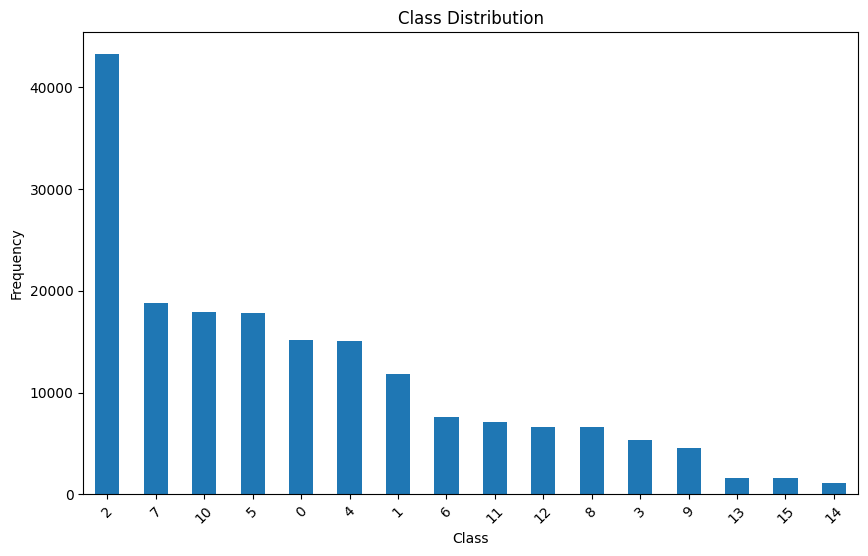

class_label
2     43260
7     18760
10    17942
5     17822
0     15165
4     15079
1     11861
6      7595
11     7124
12     6592
8      6581
3      5366
9      4515
13     1617
15     1598
14     1129
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt

# Plot the distribution of the 'class' column
plt.figure(figsize=(10,6))
train_df['class_label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()
distribution = train_df['class_label'].value_counts()
print(distribution)


In [ ]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize stopwords, lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function to clean and preprocess the text
def clean_text(text):
    # Lowercase the text
    text = text.lower()

    # Remove special characters, numbers, and non-ASCII characters
    text = re.sub(r'[^\x00-\x7F\s]', '', text)  # Remove non-ASCII characters
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters and numbers

    # Tokenization and stopword removal
    words = text.split()
    words = [word for word in words if word not in stop_words]

    # Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]

    # Join the words back into a string
    return ' '.join(words)

# Apply the cleaning function to the 'title_and_description' column
train_df['title_and_description'] = train_df['title_and_description'].apply(clean_text)
train_df


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,product_id,class_label,title_and_description,price,node_degree,core_number,avg_neighbor_degree
0,66795,9,protec classic skate independent skateboard he...,70.20,0.000018,5,235.400000
1,242781,3,callaway golf razr staff cart bag new callaway...,87.10,0.000007,2,153.000000
2,91280,2,heckler koch entourage knife combo edged bk co...,55.40,0.000072,10,27.650000
3,56356,5,reelight sl flashing extended bicycle headligh...,87.99,0.000043,10,95.250000
4,218494,0,columbia boy bug shield pant,28.80,0.000007,2,29.500000
...,...,...,...,...,...,...,...
182001,275200,0,men blood sweat tear workout tank pitbull choi...,28.80,0.000033,9,82.555556
182002,52191,2,quot x ft shock cord blk bungee cord construct...,55.00,0.000014,4,66.750000
182003,149974,1,spy optic clash wrap sunglass,77.90,0.000004,1,36.000000
182004,9664,5,token bottom bracket bb tktbt ex type integrat...,89.00,0.000007,1,28.000000


In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy.stats import zscore


# Print the number of nodes and edges before filtering
before_nodes = len(graph.nodes)
before_edges = len(graph.edges)
print(f"Before filtering:")
print(f"Number of nodes: {before_nodes}")
print(f"Number of edges: {before_edges}")

# Calculate degree centrality
degree_centrality = nx.degree_centrality(graph)

# Convert degree centrality to a numpy array for easier analysis
degree_values = np.array(list(degree_centrality.values()))

# Calculate percentiles for degree centrality
degree_25th = np.percentile(degree_values, 25)
degree_75th = np.percentile(degree_values, 75)

# Apply the threshold using percentiles:
degree_filtered_nodes = [node for node, dc in degree_centrality.items() if dc > degree_25th]

# Optionally, use z-scores to filter nodes based on degree centrality:
degree_zscore = zscore(degree_values)

# Define Z-score thresholds (e.g., nodes with Z-score < -1 or > 1 are considered extreme)
degree_zscore_filtered_nodes = [node for node, z in zip(degree_centrality.keys(), degree_zscore) if abs(z) < 1]

# Using only degree centrality filtering for the final set of nodes
important_nodes = degree_filtered_nodes

# Create a subgraph with the important nodes
G_preprocessed = graph.subgraph(important_nodes).copy()

# Print the number of nodes and edges after filtering
after_nodes = len(important_nodes)
after_edges = G_preprocessed.number_of_edges()
print(f"After filtering:")
print(f"Number of nodes: {after_nodes}")
print(f"Number of edges: {after_edges}")


Before filtering:
Number of nodes: 276453
Number of edges: 1811087
After filtering:
Number of nodes: 202332
Number of edges: 1655182


In [ ]:
import networkx as nx
import pandas as pd

# Ensure graph nodes are strings
graph_nodes = set(str(node) for node in G_preprocessed.nodes())

# Step 1: Strip any leading/trailing whitespace in 'product_id' column if needed
train_df['product_id'] = train_df['product_id'].astype(str).str.strip()

# Step 2: Filter train_df to only include rows where 'product_id' is in graph_nodes
filtered_df = train_df[train_df['product_id'].isin(graph_nodes)]

# Check if filtering worked as expected (optional debugging step)
print(f"Filtered DataFrame shape: {filtered_df.shape}")
print(f"Filtered DataFrame head:\n{filtered_df.head()}")

# Step 3: Save the filtered dataframe
filtered_df.to_csv(f'{base_dir}filtered_train_df.csv', index=False)


Filtered DataFrame shape: (137503, 7)
Filtered DataFrame head:
  product_id  class_label                              title_and_description  \
0      66795            9  protec classic skate independent skateboard he...   
2      91280            2  heckler koch entourage knife combo edged bk co...   
3      56356            5  reelight sl flashing extended bicycle headligh...   
5     169687            2    troy sraidltcxbt troy deltacx black sraidltcxbt   
6     226442            5  nashbar torque wrench take agony anguish tryin...   

    price  node_degree  core_number  avg_neighbor_degree  
0   70.20     0.000018            5               235.40  
2   55.40     0.000072           10                27.65  
3   87.99     0.000043           10                95.25  
5  217.07     0.000054           10                53.40  
6   64.99     0.000072           10                39.10  


In [ ]:
filtered_df

,product_id,class_label,title_and_description,price,node_degree,core_number,avg_neighbor_degree
0,66795,9,protec classic skate independent skateboard he...,70.20,0.000018,5,235.400000
2,91280,2,heckler koch entourage knife combo edged bk co...,55.40,0.000072,10,27.650000
3,56356,5,reelight sl flashing extended bicycle headligh...,87.99,0.000043,10,95.250000
5,169687,2,troy sraidltcxbt troy deltacx black sraidltcxbt,217.07,0.000054,10,53.400000
6,226442,5,nashbar torque wrench take agony anguish tryin...,64.99,0.000072,10,39.100000
...,...,...,...,...,...,...,...
181997,87551,2,guide gear popup ground blind guide gear popup...,49.99,0.000069,11,31.842105
181998,203691,6,valeo neoprene hand weight rubbercoated hand w...,98.10,0.000036,10,78.700000
181999,68770,2,tactical combo mount x rifle scope w target tu...,139.95,0.000047,10,57.769231
182000,218882,2,mk compound crossbow brand new powerful bow ex...,170.00,0.000141,11,22.564103


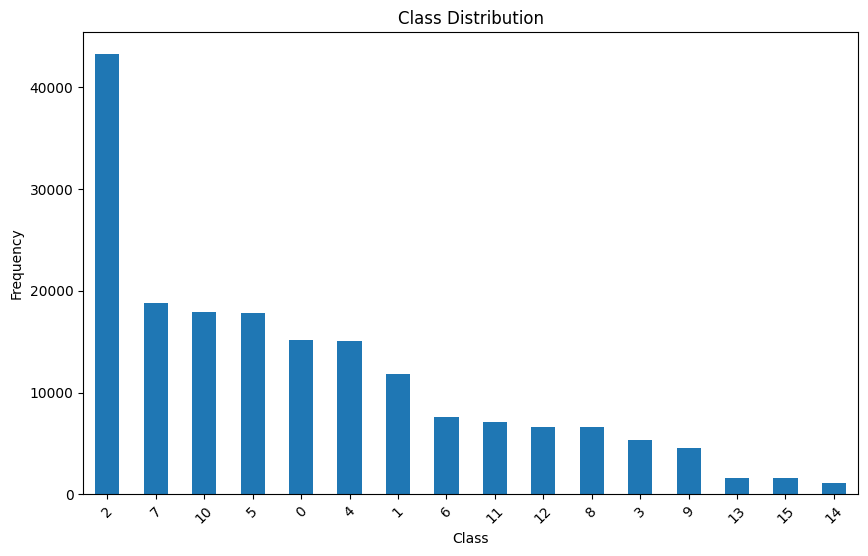

class_label
2     36709
10    15159
5     15154
4     11546
1      9369
0      9004
7      8764
6      6489
12     5694
8      5428
11     4456
3      3784
9      3651
14      882
13      764
15      650
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt

# Plot the distribution of the 'class' column
plt.figure(figsize=(10,6))
train_df['class_label'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()
distribution = filtered_df['class_label'].value_counts()
print(distribution)


In [ ]:
# prompt: make filtered_df class label last in order and extract in csv

# Move 'class_label' column to the last position
cols = list(filtered_df.columns)
cols.remove('class_label')
cols.append('class_label')
filtered_df = filtered_df[cols]

# Save the modified DataFrame to a CSV file
filtered_df.to_csv(f'{base_dir}filtered_train_df.csv', index=False)


## TEST DF

In [ ]:
# Convert 'product_id' to string in all DataFrames to ensure they match
test_ids['product_id'] = test_ids['product_id'].astype(str)
descriptions_df['product_id'] = descriptions_df['product_id'].astype(str)
prices['product_id'] = prices['product_id'].astype(str)

# Now perform the merge
test_df = test_ids.merge(descriptions_df, on='product_id', how='left')
test_df = test_df.merge(prices, on='product_id', how='left')


# Display the first few rows of the merged DataFrame with only products in y_train
test_df


,product_id,title_and_description,price
0,49957,Geigerrig Guardian Rig Tactical Hydration Pack...,133.00
1,135386,Taller Scooter 49cc Street Legal Free Matching...,749.00
2,226880,KUFA Sports Fighting Belt KUFA Sports Fighting...,18.53
3,165114,Stainless Steel 304 Spring Snap Hook Carabiner...,NaN
4,256154,Bushnell Trophy XLT Multi-X Reticle Riflescope...,119.95
...,...,...,...
45497,182494,Blue Force Gear Vickers Black 2-Pt Combat Slin...,42.12
45498,233968,Sako Optilok Scope Mount Base Sako Optilok Sco...,NaN
45499,175781,MLB New York Yankees MLB Basic Stm/Gry 59Fifty...,NaN
45500,194617,USA GunClub Easy Use Gun Hanger Pack of 4 Orig...,13.99


In [ ]:


# Create a graph from the edgelist
graph = nx.from_pandas_edgelist(edgelist, 'source', 'target')

# Ensure product_id is the same type as nodes in the graph
test_df['product_id'] = test_df['product_id'].astype(type(list(graph.nodes)[0]))

# Calculate node degree
degree_centrality = nx.degree_centrality(graph)
# Calculate core number
core_number = nx.core_number(graph)
# Calculate average neighbor degree
avg_neighbor_degree = nx.average_neighbor_degree(graph)

# Create lists to store the features
degree_list = []
core_list = []
avg_neighbor_list = []

# Iterate through product IDs in the test_df
for product_id in test_df['product_id']:
    try:
        degree_list.append(degree_centrality[product_id])
        core_list.append(core_number[product_id])
        avg_neighbor_list.append(avg_neighbor_degree[product_id])
    except KeyError:
        # Handle cases where product_id is not in the graph
        degree_list.append(0)  # Or another default value
        core_list.append(0)
        avg_neighbor_list.append(0)

# Append features as columns to the DataFrame
test_df['node_degree'] = degree_list
test_df['core_number'] = core_list
test_df['avg_neighbor_degree'] = avg_neighbor_list
test_df

,product_id,title_and_description,price,node_degree,core_number,avg_neighbor_degree
0,49957,Geigerrig Guardian Rig Tactical Hydration Pack...,133.00,0.000025,7,62.285714
1,135386,Taller Scooter 49cc Street Legal Free Matching...,749.00,0.000047,10,41.307692
2,226880,KUFA Sports Fighting Belt KUFA Sports Fighting...,18.53,0.000076,10,58.095238
3,165114,Stainless Steel 304 Spring Snap Hook Carabiner...,NaN,0.000036,10,88.500000
4,256154,Bushnell Trophy XLT Multi-X Reticle Riflescope...,119.95,0.000036,10,77.500000
...,...,...,...,...,...,...
45497,182494,Blue Force Gear Vickers Black 2-Pt Combat Slin...,42.12,0.000036,10,48.700000
45498,233968,Sako Optilok Scope Mount Base Sako Optilok Sco...,NaN,0.000022,2,5.166667
45499,175781,MLB New York Yankees MLB Basic Stm/Gry 59Fifty...,NaN,0.000014,4,81.000000
45500,194617,USA GunClub Easy Use Gun Hanger Pack of 4 Orig...,13.99,0.000311,11,16.441860


In [ ]:


# Calculate the mean price for all products in the test set
mean_price = test_df['price'].mean()

# Function to fill NaN prices with the mean price
def fill_nan_prices_test(row):
    if pd.isna(row['price']):
        return np.round(mean_price, 1)
    else:
        return row['price']

# Apply the function to fill NaN values in the 'price' column of test_df
test_df['price'] = test_df.apply(fill_nan_prices_test, axis=1)

# Display the updated test DataFrame
test_df.rename(columns={'title_and_description': 'text'}, inplace=True)
test_df


,product_id,text,price,node_degree,core_number,avg_neighbor_degree
0,49957,Geigerrig Guardian Rig Tactical Hydration Pack...,133.00,0.000025,7,62.285714
1,135386,Taller Scooter 49cc Street Legal Free Matching...,749.00,0.000047,10,41.307692
2,226880,KUFA Sports Fighting Belt KUFA Sports Fighting...,18.53,0.000076,10,58.095238
3,165114,Stainless Steel 304 Spring Snap Hook Carabiner...,58.30,0.000036,10,88.500000
4,256154,Bushnell Trophy XLT Multi-X Reticle Riflescope...,119.95,0.000036,10,77.500000
...,...,...,...,...,...,...
45497,182494,Blue Force Gear Vickers Black 2-Pt Combat Slin...,42.12,0.000036,10,48.700000
45498,233968,Sako Optilok Scope Mount Base Sako Optilok Sco...,58.30,0.000022,2,5.166667
45499,175781,MLB New York Yankees MLB Basic Stm/Gry 59Fifty...,58.30,0.000014,4,81.000000
45500,194617,USA GunClub Easy Use Gun Hanger Pack of 4 Orig...,13.99,0.000311,11,16.441860


In [ ]:
test_df.to_csv(f'{base_dir}test_df.csv', index=False)

## FINAL DF

In [ ]:
import pandas as pd
filtered_train_df_path= '/content/drive/MyDrive/Data Science AUEB/Data Challenge/data/filtered_train_df.csv'
augmented_train_df_path= '/content/drive/MyDrive/Data Science AUEB/Data Challenge/data/augmented_train_df.csv'

# Load the DataFrames
filtered_train_df = pd.read_csv(filtered_train_df_path)
augmented_train_df = pd.read_csv(augmented_train_df_path)

# Merge the DataFrames on the 'product_id' column, with priority to augmented_train_df
final_df = augmented_train_df.set_index('product_id').combine_first(filtered_train_df.set_index('product_id'))
final_df = final_df.rename(columns={'title_and_description': 'text'})

# Reset index to make 'product_id' a column again
final_df.reset_index(inplace=True)
final_df.sort_values(by='product_id', inplace=True)

# Reorder columns in final_df
desired_order = ['product_id', 'text', 'price', 'node_degree', 'core_number', 'avg_neighbor_degree', 'class_label']
final_df = final_df[desired_order]
final_df = final_df.dropna(subset=['text'])

final_df

,product_id,text,price,node_degree,core_number,avg_neighbor_degree,class_label
0,0,fsa orbit z zero stack internal bicycle headse...,50.50,0.000036,8,70.700000,5
1,1,columbia bugaboo ii footbyfoot pole person dom...,54.30,0.000036,10,111.200000,10
2,2,men new gym workout short gary majdell sport,17.97,0.000036,10,202.200000,0
3,4,real avid zipwire pistol cleaning kit real avi...,36.60,0.000047,10,80.153846,2
4,5,harvard sport trainer harvard sport trainer le...,199.95,0.000040,10,44.636364,8
...,...,...,...,...,...,...,...
156400,276448,abu garcia c ambassadeur c baitcast round reel...,112.99,0.000043,10,115.166667,2
156402,276450,australian outrider airflow trayvil pad black ...,36.00,0.000022,4,7.666667,15
156401,276450,australian outrider airflow trail pad black ai...,36.00,0.000022,4,7.666667,15
156403,276450,australian outrider airflow pad black air flow...,36.00,0.000022,4,7.666667,15


In [ ]:
final_df.to_csv(f'{base_dir}final_df.csv', index=False)